In [1]:
import pandas as pd
import numpy as np
import torch
import os
import librosa
import sys

sys.path.append('Datasets/')
sys.path.append('models/')

import datasets
import audio_utils
import models

In [2]:
SCAPPER_DF = pd.read_csv('predictions/scapper_scenePredictions_model00.csv')
TUT_DF = pd.read_csv('predictions/TUT18_test_baseline_predictions.csv')
TUT_AUD_DIR = '../audioData/TUTUrban2018/developmentDataset/TUT-urban-acoustic-scenes-2018-development/'
SCAPPER_AUD_DIR = '../audioData/sythenticSoundscenes/test'
scapper_acoustic_scenes = (list)(SCAPPER_DF['acoustic_scene_label'].unique())
tut_acoustic_scenes = (list)(TUT_DF['labels'].unique())

In [3]:
SCAPPER_DF

audio_fileNames              label_fileNames  \
0                    bus10_0.wav                 bus10_0.jams   
1                    bus10_1.wav                 bus10_1.jams   
2                    bus10_2.wav                 bus10_2.jams   
3                    bus10_3.wav                 bus10_3.jams   
4                    bus10_4.wav                 bus10_4.jams   
...                          ...                          ...   
2995  tubestation9_upshift_5.wav  tubestation9_upshift_5.jams   
2996  tubestation9_upshift_6.wav  tubestation9_upshift_6.jams   
2997  tubestation9_upshift_7.wav  tubestation9_upshift_7.jams   
2998  tubestation9_upshift_8.wav  tubestation9_upshift_8.jams   
2999  tubestation9_upshift_9.wav  tubestation9_upshift_9.jams   

     acoustic_scene_label                                  events_label_list  \
0                     bus  ['cough', 'phone', 'keys', 'phone', 'cough', '...   
1                     bus  ['keys', 'clearthroat', 'laughter', 'keys', 'p...   
2                     bus  ['laughter', 'keys', 'phone', 'phone', 'cough'...   
3                     bus  ['phone', 'keys', 'phone', 'laughter', 'speech...   
4                     bus  ['laughter', 'keys', 'phone', 'cough', 'cleart...   
...                   ...                                                ...   
2995          tubestation  ['mindthegap', 'footsteps', 'slidingDoorclose'...   
2996          tubestation  ['mindthegap', 'mindthegap', 'train', 'mindthe...   
2997          tubestation                               ['slidingDoorclose']   
2998          tubestation  ['speech', 'slidingDoorclose', 'footsteps', 's...   
2999          tubestation  ['slidingDoorclose', 'train', 'train', 'speech...   

     ASC_predictions_model00  
0                     office  
1                     office  
2                     office  
3                        bus  
4                     office  
...                      ...  
2995             tubestation  
2996             tubestation  
2997             tubestation  
2998             tubestation  
2999             tubestation  

[3000 rows x 5 columns]

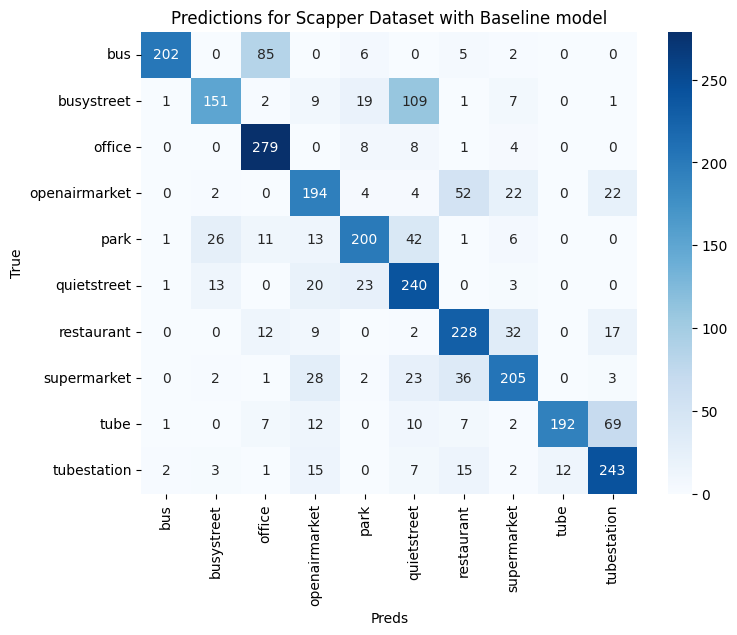

In [50]:
tru = SCAPPER_DF['acoustic_scene_label'] 
#tru = TUT_DF['labels']
#pred = SCAPPER_DF['scene_predictions']
pred = SCAPPER_DF['ASC_predictions_model00']
#pred = TUT_DF['preds']
#pred = SCAPPER_DF['ASC_predictions_model00']

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(tru, pred, labels=scapper_acoustic_scenes)

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=scapper_acoustic_scenes, yticklabels=scapper_acoustic_scenes)
plt.xlabel('Preds')
plt.ylabel('True')
plt.title('Predictions for Scapper Dataset with Baseline model')
plt.show()

In [4]:
#model_path = 'ASC_Model00_scapper_30epochs_00_statedict.pt'
model_path = 'ASC_Model00_scapper_20epochs_00_statedict.pt'
#model_path = 'ASC_Model00_TUT18_20epochs_00_statedict.pt'
model = models.ASC_Model00(return_second_last=False)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

def get_logMel_from_fname(audio_fname):
    audio = audio_utils.load_audio_from_file(audio_fname, sample_rate=16000)
    log_mel = audio_utils.get_log_melSpectrogram(audio)
    return log_mel

def zero_signal(log_mel, index):
    log_mel[0][index] = torch.ones(log_mel[0][index].shape) * log_mel.min()
    return log_mel

def run_loop(audio_fname, model):
    feat_inva_output_list = []
    input_feats = get_logMel_from_fname(audio_fname)

    n_features = input_feats.shape[1]

    for i in range(n_features):
        input_feats = get_logMel_from_fname(audio_fname)
        input_log_mel = zero_signal(input_feats, i)
        #input_log_mel = zero_signal(input_log_mel, 2)

        model.eval()
        with torch.inference_mode():
            predictions = model(input_log_mel.unsqueeze(0).to(device))
            predictions = scapper_acoustic_scenes[torch.argmax(torch.sigmoid(predictions.cpu()))]
            #predictions = tut_acoustic_scenes[torch.argmax(torch.sigmoid(predictions.cpu()))]
            #print(predictions)
        feat_inva_output_list.append(predictions)
    return feat_inva_output_list

In [6]:
import random
randomly_chosen_files = {}

for i in scapper_acoustic_scenes:
    randomly_chosen_files[i] = []
scapper_true = SCAPPER_DF[SCAPPER_DF['acoustic_scene_label'] == SCAPPER_DF['ASC_predictions_model00']]
#tut_true = TUT_DF[TUT_DF['labels'] == TUT_DF['preds']]
    

In [7]:
for i in scapper_acoustic_scenes:
    rand = (list)(scapper_true[scapper_true['acoustic_scene_label'] == i]['audio_fileNames'])
    #rand = (list)(tut_true[tut_true['labels'] == i]['files'])
    random.seed(13)
    #print(rand)
    randomly_chosen_files[i].append(random.sample(rand,20))

In [8]:
predictions_dictionary = {}

for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        audio_fname = os.path.join(SCAPPER_AUD_DIR, j)
        #audio_fname = os.path.join(TUT_AUD_DIR, j)
        predictions_dictionary[j] = run_loop(audio_fname, model)
        

In [9]:
new_counter_dict = {}

for i in scapper_acoustic_scenes:
    new_counter_dict[i] = [0 for j in range(40)]

In [13]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

tru = []
preds = []
for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        for k, row in enumerate(predictions_dictionary[j]):
            tru.append(i)
            preds.append(predictions_dictionary[j][k])
            if predictions_dictionary[j][k] != i:
                new_counter_dict[i][k] += 1
                #print(i, predictions_dictionary[j][k], k)

<Axes: >

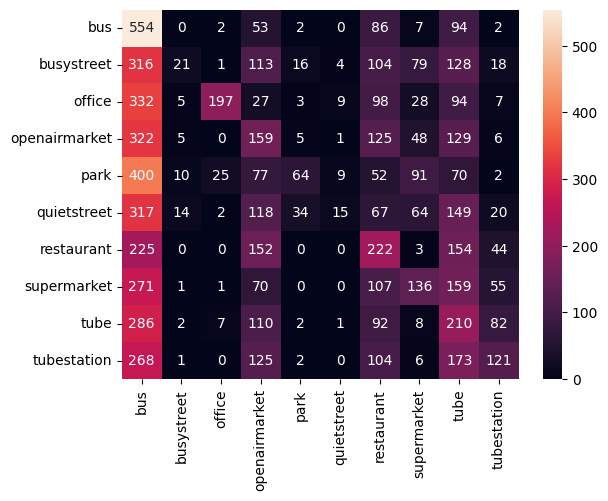

In [14]:
cm = confusion_matrix(tru, preds, labels=scapper_acoustic_scenes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=scapper_acoustic_scenes, yticklabels=scapper_acoustic_scenes)

<Axes: title={'center': 'Feaeture Ablation for Scapper test using Baseline model'}>

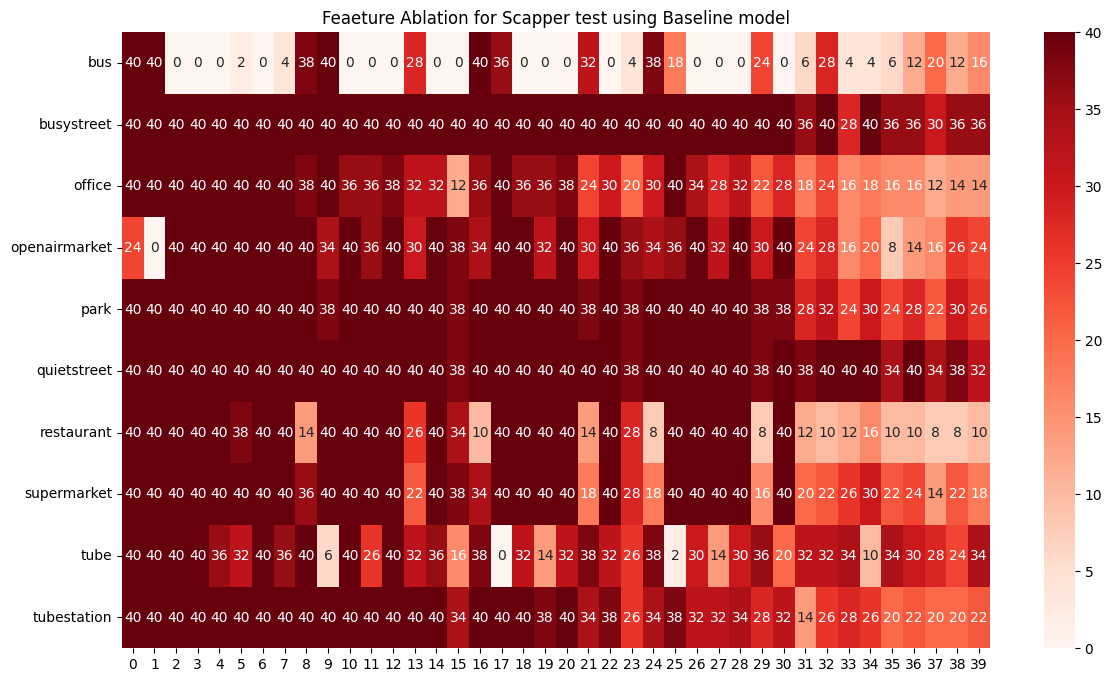

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.title('Feaeture Ablation for Scapper test using Baseline model')
sns.heatmap(pd.DataFrame(new_counter_dict).transpose(), annot=True, fmt='d', cmap='Reds')

<Axes: >

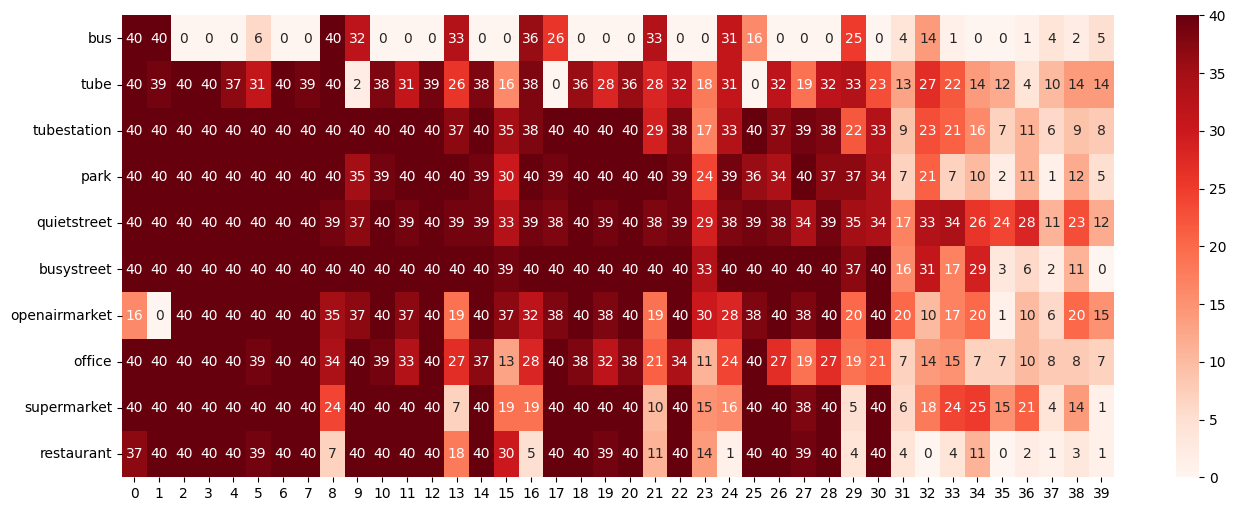

In [92]:
new_index = ['bus', 'tube', 'tubestation', 'park', 'quietstreet', 'busystreet', 'openairmarket', 'office', 'supermarket', 'restaurant']
new_counter_dict_df =  pd.DataFrame(new_counter_dict)
#new_counter_dict_list = list(new_counter_dict.keys())
#old = new_counter_dict_df.columns.tolist()
new_counter_dict_df = new_counter_dict_df.reindex(columns=new_index)

plt.figure(figsize=(16, 6))
sns.heatmap(new_counter_dict_df.transpose(), annot=True, fmt='d', cmap='Reds')

In [124]:
tru = []
pred = []
model = model.to(device)

for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        audio_fname = os.path.join(SCAPPER_AUD_DIR, j)
        input_feats = get_logMel_from_fname(audio_fname)
        tru.append(i)

        model.eval()
        with torch.inference_mode():
            predictions = model(input_feats.unsqueeze(0).to(device))
            predictions = scapper_acoustic_scenes[torch.argmax(torch.sigmoid(predictions.cpu()))]
        pred.append(predictions)

In [125]:
check_preds_dict = {}

for i in scapper_acoustic_scenes:
    check_preds_dict[i] = [0 for j in range(40)]

for i in randomly_chosen_files.keys():
    for j in randomly_chosen_files[i][0]:
        prediction_list = predictions_dictionary[os.path.join(SCAPPER_AUD_DIR,j)]
        for k in prediction_list:
            print(k, i)
            if k != i:
                check_preds_dict[i][(prediction_list.index(k))] = check_preds_dict[i][(prediction_list.index(k))]+1
                #print(check_preds_dict[i][(prediction_list.index(k))])

KeyError: '../audioData/sythenticSoundscenes/test/bus1_upshift_7.wav'

<Axes: >

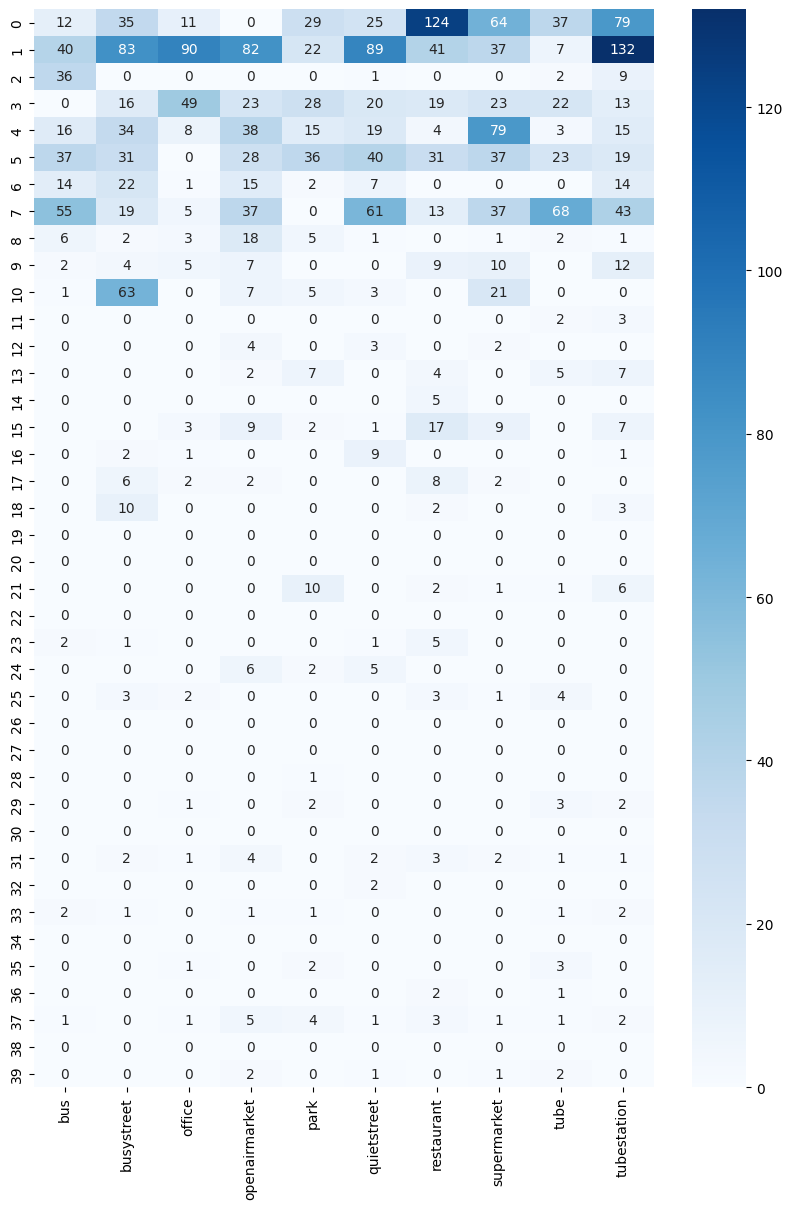

In [23]:
plt.figure(figsize=(10,14))
sns.heatmap(pd.DataFrame(check_preds_dict), annot=True, fmt='d',cmap='Blues')

In [126]:
tru = []
preds = []

for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        audio_fname = os.path.join(SCAPPER_AUD_DIR, j)
        for k in predictions_dictionary[audio_fname]:
            tru.append(i)
            preds.append(k)

cm = confusion_matrix(tru, preds)
plt.figure(figsize=(8, 5))
plt.title('Heatmap for the mispredictions after feature ablation')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tut_acoustic_scenes, yticklabels=tut_acoustic_scenes)
plt.xlabel('Preds')
plt.ylabel('True')
plt.show()

KeyError: '../audioData/sythenticSoundscenes/test/bus1_upshift_7.wav'

In [101]:
x_list = []
for i in randomly_chosen_files.keys():
    #test_dict[i] = {}
    inner_list = []
    for j in randomly_chosen_files[i][0]:
        prediction_list = predictions_dictionary[os.path.join(SCAPPER_AUD_DIR,j)]
        for k in prediction_list:
            if k != i:
                #print(prediction_list.index(k), i)
                inner_list.append(prediction_list.index(k))
    x_list.append(inner_list)
        


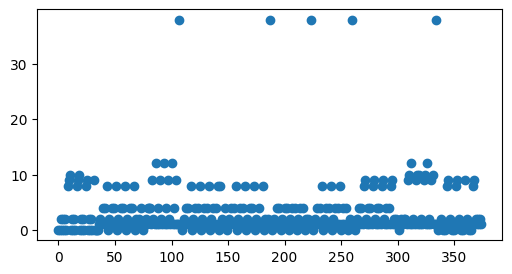

In [105]:
y_axis = [i for i in range(41)]

plt.figure(figsize=(6, 3))
plt.scatter([i for i in range((len(x_list[7])))], x_list[7])


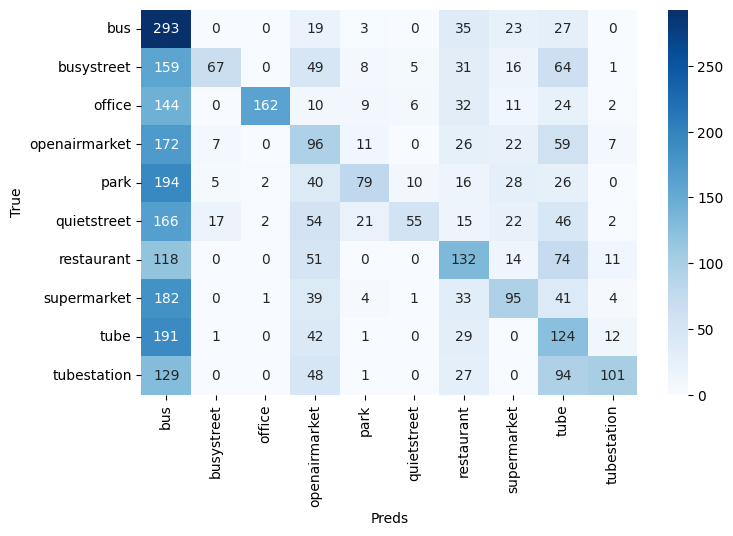

In [132]:
tru = []
preds = []

for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        audio_fname = os.path.join(SCAPPER_AUD_DIR, j)
        prediction_list = predictions_dictionary[os.path.join(SCAPPER_AUD_DIR,j)]
        for k in prediction_list:
            tru.append(i)
            preds.append(k)

cm = confusion_matrix(tru, preds)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=scapper_acoustic_scenes, yticklabels=scapper_acoustic_scenes)
plt.xlabel('Preds')
plt.ylabel('True')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


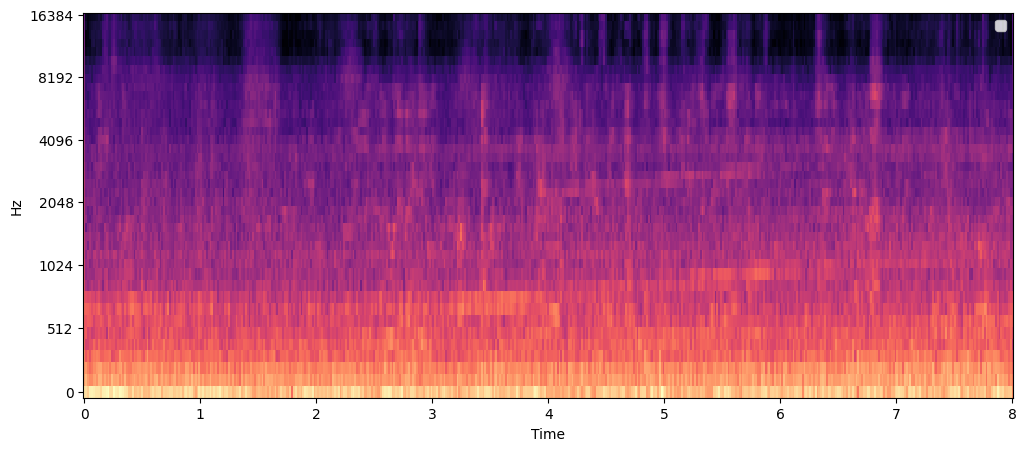

In [99]:
import librosa
import matplotlib.pyplot as plt

#sample_file = '../audioData/sythenticSoundscenes/test/bus1_9.wav'
sample_file = '561.wav'
audio = audio_utils.load_audio_from_file(sample_file)
log_mel_feats = audio_utils.get_log_melSpectrogram(audio)

plt.figure(figsize=(12, 5))
librosa.display.specshow(log_mel_feats.squeeze().numpy(), x_axis='time', y_axis='mel', sr=32000)
plt.legend()

In [97]:
from IPython.display import Audio, display

display(Audio(sample_file))

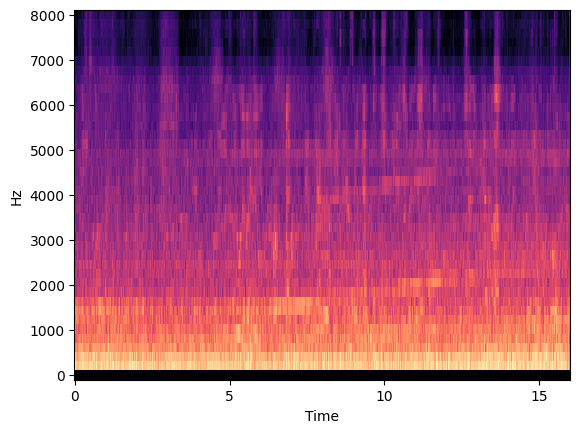

In [100]:
new_log_mel = zero_signal(log_mel_feats,0)
#log_mel_feats[0][25] = torch.ones(log_mel_feats[0][8].shape) * log_mel_feats.min()
librosa.display.specshow(log_mel_feats.squeeze().numpy(), x_axis='time', y_axis='linear', sr=16000) #new_log_mel

In [110]:
torch.ones(log_mel_feats[0].shape) * log_mel_feats.min()

tensor([[-80., -80., -80.,  ..., -80., -80., -80.],
        [-80., -80., -80.,  ..., -80., -80., -80.],
        [-80., -80., -80.,  ..., -80., -80., -80.],
        ...,
        [-80., -80., -80.,  ..., -80., -80., -80.],
        [-80., -80., -80.,  ..., -80., -80., -80.],
        [-80., -80., -80.,  ..., -80., -80., -80.]])

In [88]:
torch.ones(new_log_mel[0].shape) * 0.2

tensor([[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]])

In [73]:
model.eval()
with torch.inference_mode():
    output = model(log_mel_feats.unsqueeze(0))
    #print(output)

torch.argmax(torch.sigmoid(output))

tensor(2)

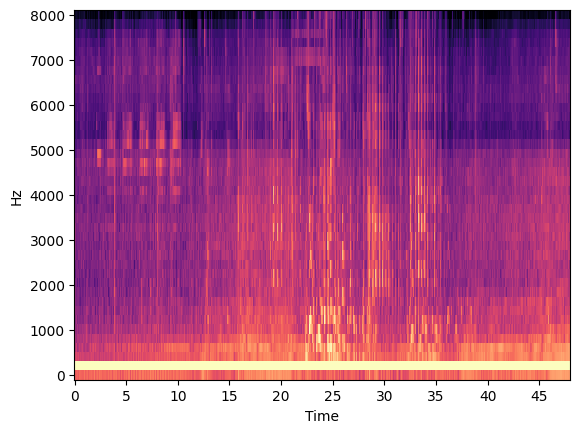

In [74]:
log_mel_feats[0][1] = torch.zeros(log_mel_feats[0][5].shape)

librosa.display.specshow(log_mel_feats.squeeze().numpy(), x_axis='time', y_axis='linear', sr=16000)

In [75]:
model.eval()
with torch.inference_mode():
    output = model(log_mel_feats.unsqueeze(0))

torch.argmax(torch.sigmoid(output))

tensor(0)